# Finds Angle Between Angular Momentum & Figure Rotation Axis 

Basic calculation of angle between angular momentum axis (non-tilted-ring model) and figure rotation axis for many snapshots. Calcuated for all halos in Neil Ash's catalog. Does some very basic visualization. Requires angular momentum calculations for inputted boundary radii and snapshots.

## Basic Setup

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
from os.path import exists
import os
import numpy as np
import h5py
from tqdm import tqdm
from numpy.linalg import inv
from scipy import stats

sim = 'L35n2160TNG'
basePath = '/home/tnguser/sims.TNG/' + sim + '/output'
savePath = '/home/tnguser/postprocessing/angles/'+ sim + '/00_15Rvir/'
pattern_path =  '/home/tnguser/postprocessing/pattern_speeds/' + sim + '/00_06Rvir/'
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'

catalogue_path = '/home/tnguser/postprocessing/halocatalogues/' + sim + '.npy'
naive_halos = np.load(catalogue_path)
main_subhalos = np.load('/home/tnguser/postprocessing/halocatalogues/' + sim + '_mainSubhalos.npy') 

snap = 99
startSnap = 75

In [1]:
# HELPER FUNCTION

def getRotationAxis(snap, startStops, Raxis):
    for idx, (first,second) in enumerate(startStops):
        if (snap >= first and snap < second):
            return Raxis[idx]
    return Raxis[-1]

## Calculate the angle between the rotation axis and spin axis (deg)

In [33]:
spin_path = '/home/tnguser/postprocessing/spin/' + sim + '/00_06Rvir/'
pattern_path =  '/home/tnguser/postprocessing/pattern_speeds/' + sim + '/00_06Rvir/'
principal_path =  '/home/tnguser/postprocessing/principal_axes/' + sim + '/00_06Rvir/'

num_skipped = 0
num_saved = 0
all_angles = []

for GrNr in naive_halos:
    if GrNr != -1:
        spin_file = spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,startSnap)
        pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
        principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,startSnap)
        
        if exists(spin_file) and exists(pattern_file) and exists(principal_file):
            spins = np.load(spin_file,allow_pickle=True)
            pattern_info = np.load(pattern_file, allow_pickle=True)
            pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
            assert(pattern_info['GrNr']==GrNr)
            principal_axes = np.load(principal_file,allow_pickle=True)
            
            # looping over each snap 75 - 99
            angles = []
            for snap in np.arange(25):
                raxis = np.dot(principal_axes[snap], getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis']))
                angle = np.degrees(np.arccos(np.dot(raxis, spins[0][snap])))
                angles.append(angle)
                all_angles.append(angle)
            
            save_name = savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)
            np.save(save_name,angles,allow_pickle=True)
            num_saved += 1
        
        else:
            num_skipped += 1

print('saved ', num_saved, 'halos')
print('skipped ', num_skipped, 'halos')

saved  1396 halos
skipped  358 halos


Text(0, 0.5, 'N')

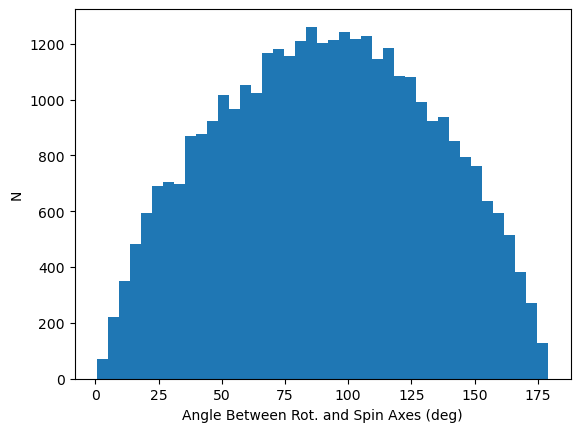

In [34]:
plt.hist(all_angles, 'scott')
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')

In [ ]:
# spot check 10 random subhalos to make sure

for GrNr in [9989,9092,8519,8229,7758,7236,6161,5121,2895,10508]:
    print('For GrNr: ', GrNr)
    spin_file = spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,startSnap)
    pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
    principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,startSnap)

    spins = np.load(spin_file,allow_pickle=True)
    pattern_info = np.load(pattern_file, allow_pickle=True)
    pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
    principal_axes = np.load(principal_file,allow_pickle=True)
            
    snap = 24
    raxis = np.dot(principal_axes[snap], getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis']))
    angle = np.degrees((np.arccos(np.dot(raxis, spins[0][snap]))))
    
    print("Rotation Axis: ", raxis, np.sqrt(np.sum(raxis**2)))
    print("Spin Axis: ", spins[0][snap], np.sqrt(np.sum(spins[0][snap]**2)))
    print('dot product: ', np.dot(raxis, spins[0][snap]))
    print("Angle Between: ", angle)
    print()
    print()

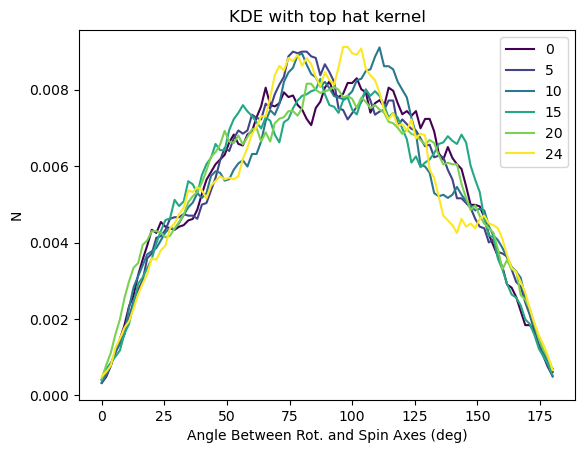

In [64]:
save06Path = '/home/tnguser/postprocessing/angles/'+ sim + '/00_06Rvir/'
sorted_angles = np.empty([1,25])
for GrNr in naive_halos:
    angle_file = save06Path+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)
    if exists(angle_file):
        temp = np.load(angle_file,allow_pickle=True)
        sorted_angles = np.vstack((sorted_angles, temp))
        
h = [silverman(sorted_angles[:,i]) for i in np.arange(25)]
x = np.linspace(0,180,100)

KDE_data = [KDE(x, h[i], sorted_angles[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=str(i))
    
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')
plt.title('KDE with top hat kernel')
plt.legend()

## Finding subhalos with figure rotation axis aligned within 20 deg of minor axis of DM halo

In [57]:
allAngles_minor = []
for GrNr in naive_halos:
    if GrNr != -1:
        pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
        
        if exists(pattern_file):
            pattern_info = np.load(pattern_file, allow_pickle=True)
            pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
            
            # looping over each snap 75 - 99
            angles = []
            for snap in np.arange(25):
                angle = np.degrees(np.arccos(np.dot([0,0,1],getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis']))))
                angles.append(angle)
                allAngles_minor.append(angle)
            
            save_name = savePath+'GrNr_%d_snap_%d_99_minorAngle.npy'%(GrNr,startSnap)
            np.save(save_name,angles,allow_pickle=True)

Text(0, 0.5, 'N')

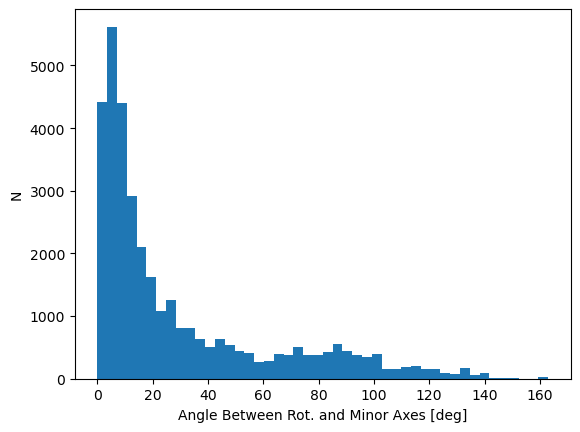

In [64]:
plt.hist(allAngles_minor, 'scott')
plt.xlabel('Angle Between Rot. and Minor Axes [deg]')
plt.ylabel('N')

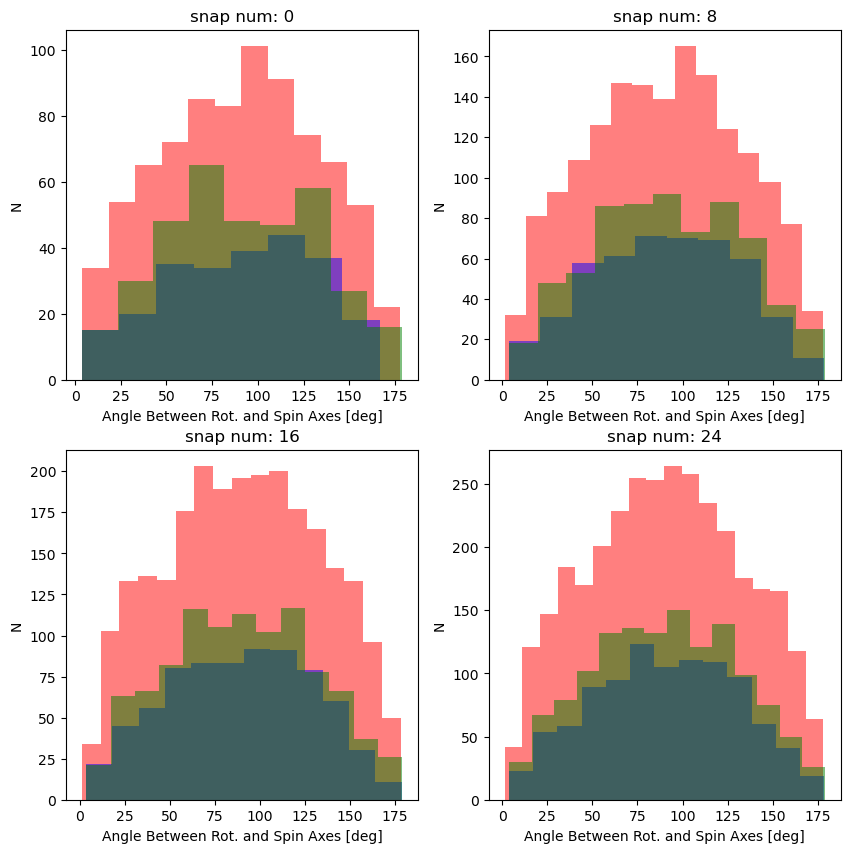

In [73]:
angles_under20 = []
angles_under45 = []
angles_under90 = []

fig = plt.figure(figsize=(10,10))

for n, snap in enumerate([0,8,16,24]):
    ax = plt.subplot(2, 2, n + 1)
    for GrNr in naive_halos:
        minorAngle_file = savePath + 'GrNr_%d_snap_%d_99_minorAngle.npy'%(GrNr,startSnap)
        if (GrNr != -1 and exists(minorAngle_file)):
            angleMinor = np.load(savePath + 'GrNr_%d_snap_%d_99_minorAngle.npy'%(GrNr,startSnap),allow_pickle=True)[snap]
            angleRaxis = np.load(savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap),allow_pickle=True)[snap]
            if (angleMinor <= 20):
                angles_under20.append(angleRaxis)
            elif (angleMinor <= 45):
                angles_under45.append(angleRaxis)
            else:
                angles_under90.append(angleRaxis)
                
    ax.hist(angles_under20,'scott',color='r',alpha=0.5,)            
    ax.hist(angles_under45,'scott',color='b',alpha=0.5,)
    ax.hist(angles_under90,'scott',color='g',alpha=0.5,)
    ax.set_title('snap num: ' + str(snap))
    ax.set_ylabel('N')
    ax.set_xlabel('Angle Between Rot. and Spin Axes [deg]')

## Relation over time

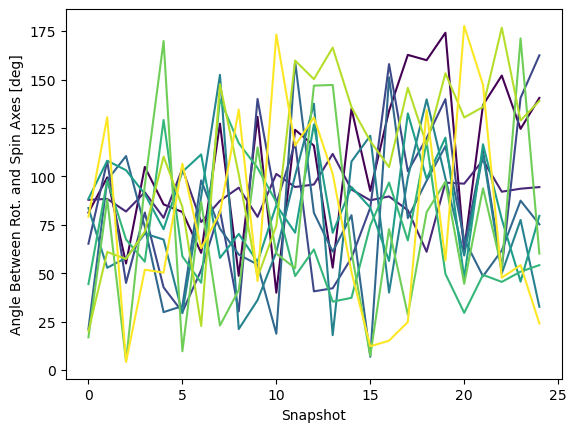

In [78]:
x = np.arange(25)
colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i,GrNr in enumerate([9989,9092,8519,8229,7758,7236,6161,5121,2895,10508]):
    angleRaxis = np.load(savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap),allow_pickle=True)
    plt.plot(x, angleRaxis, color=colors[i])
    plt.xlabel('Snapshot')
    plt.ylabel('Angle Between Rot. and Spin Axes [deg]')

Text(0.5, 0.92, 'Spin Axis Over Time')

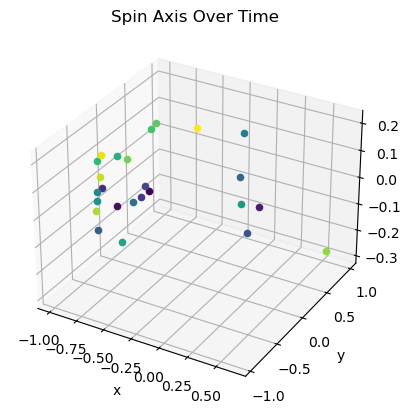

In [97]:
x = np.arange(25)
colors = plt.cm.viridis(np.linspace(0, 1, 25))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

GrNr = 9989
spinAxis = np.load(spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,startSnap),allow_pickle=True)[0]
for snap in np.arange(25):
    ax.scatter(spinAxis[snap][0],spinAxis[snap][1],spinAxis[snap][2], color=colors[snap])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spin Axis Over Time')

### Looking At Subhalo Spin Over Time

Text(0.5, 0.92, 'Spin Axis Over Time')

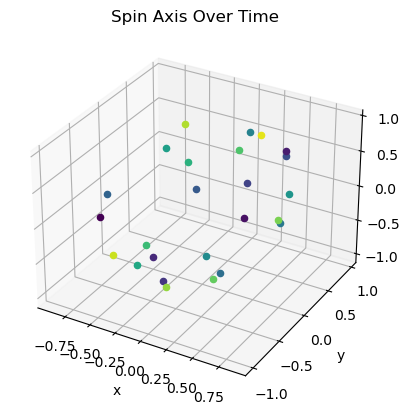

In [6]:
# looking at example spin axes over time
x = np.arange(25)
colors = plt.cm.viridis(np.linspace(0, 1, 26))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

spins = []
for i in np.arange(25):
    spin = il.groupcat.loadSingle(basePath,75+i,subhaloID=22032)['SubhaloSpin']
    spin = spin/(np.sqrt(np.sum(spin**2)))
    spins.append(spin)
    ax.scatter(spin[0],spin[1],spin[2], color=colors[i])

plt.xlabel('x')
plt.ylabel('y')
plt.title('Spin Axis Over Time')

Text(0, 0.5, 'Angle Between Spins Axes')

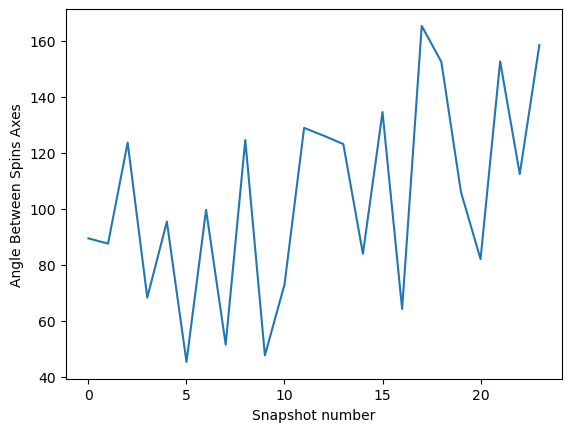

In [17]:
sub_angles = []
for i, vec in enumerate(spins):
    if i < len(spins)-1:
        sub_angles.append(getAngle(vec, spins[i+1]))
        
plt.plot(np.arange(24),sub_angles)
plt.xlabel('Snapshot number')
plt.ylabel('Angle Between Spins Axes')

### Looking at Angle Between Subhalo Spin and Rotation Axis

In [3]:
num_skipped = 0
num_saved = 0
all_angles = []

for GrNr,subfindID in zip(naive_halos,main_subhalos):
    if GrNr != -1:
        pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
        principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,startSnap)
        
        if exists(pattern_file) and exists(principal_file):
            pattern_info = np.load(pattern_file, allow_pickle=True)
            pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
            principal_axes = np.load(principal_file,allow_pickle=True)
            
            # looping over each snap 75 - 99
            angles = []
            for snap in np.arange(25):
                spin = il.groupcat.loadSingle(basePath,75+snap,subhaloID=subfindID)['SubhaloSpin']
                spin = spin/(np.sqrt(np.sum(spin**2)))
                spin_bf = np.dot(np.linalg.inv(principal_axes[snap]), spin)
                
                raxis = getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis'])
                
                angle = np.degrees(np.arccos(np.dot(raxis, spin_bf)))
                angles.append(angle)
                all_angles.append(angle)
            
            save_name = savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle2.npy'%(GrNr,startSnap)
            np.save(save_name,angles,allow_pickle=True)
            num_saved += 1
        
        else:
            num_skipped += 1

print('saved ', num_saved, 'halos')
print('skipped ', num_skipped, 'halos')

saved  1396 halos
skipped  358 halos


Text(0, 0.5, 'N')

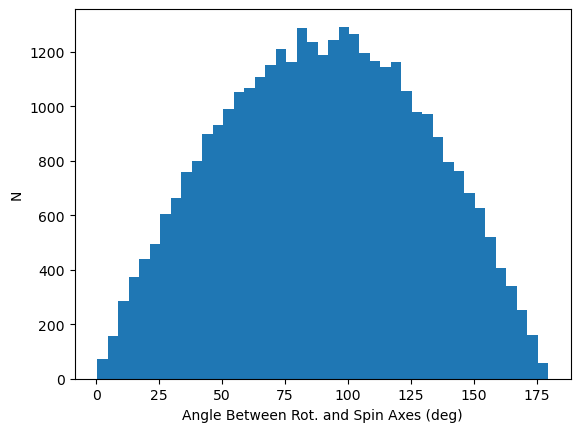

In [4]:
plt.hist(all_angles, 'scott')
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')

In [8]:
allAngles_minor = []

for GrNr in naive_halos:
    if GrNr != -1:
        spin_file = savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle2.npy'%(GrNr,startSnap)
        if exists(spin_file):
            spins = np.load(spin_file, allow_pickle=True)

            angles = []
            for snap in np.arange(25):
                angle = np.degrees(np.arccos(np.dot([0,0,1],spins[snap])))
                angles.append(angle)
                allAngles_minor.append(angle)

            save_name = savePath+'GrNr_%d_snap_%d_99_minorAngle2.npy'%(GrNr,startSnap)
            np.save(save_name,angles,allow_pickle=True)    

/tmp/ipykernel_25/3092356396.py:11: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(np.dot([0,0,1],spins[snap])))


In [ ]:
plt.hist(allAngles_minor, 'scott')
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')

Calculates angle between angular momentum axis and figure rotation axis for all halos in Neil's catalog. Calculates angle in the simulation frame. ***Requires that angular momentum is already calculated for stars with radii in [innerVirialLim, outerVirialLim] for all snapshots between startSnap and 99.

In [8]:
innerVirialLim = 0
outerVirialLim = 15.
momentum_path = '/home/tnguser/postprocessing/angular_momentum/' + sim + '/%02d_%02dRvir/'%(innerVirialLim,outerVirialLim)
savePath = '/home/tnguser/postprocessing/angles/'+ sim + '/%02d_%02dRvir/'%(innerVirialLim,outerVirialLim)

if not os.path.exists(savePath):
    os.mkdir(savePath)

num_skipped = 0
num_saved = 0
all_angles = []

for GrNr in naive_halos:
    if GrNr != -1:
        momentum_file = spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,startSnap) # 
        pattern_file = pattern_path + 'GrNr_%d_snap_%d_99_patternSpeeds.npy'%(GrNr,startSnap)
        principal_file = principal_path + 'GrNr_%d_snap_%d_99_principal_axes_full.npy'%(GrNr,startSnap)
        
        # Must have angular momentum, pattern speeds, and principal axes calculations
        if exists(momentum_file) and exists(pattern_file) and exists(principal_file):
            spins = np.load(momentum_file,allow_pickle=True)
            pattern_info = np.load(pattern_file, allow_pickle=True)
            pattern_info = dict(enumerate(pattern_info.flatten(),1))[1]
            principal_axes = np.load(principal_file,allow_pickle=True)
            
            # Calculates angle between roation and angular momentum axes for snaphots startSnap - 99
            angles = []
            for snap in np.arange(25):
                raxis = np.dot(principal_axes[snap], getRotationAxis(snap, pattern_info['startStop'], pattern_info['Raxis']))
                angle = np.degrees(np.arccos(np.dot(raxis, spins[snap])))
                angles.append(angle)
                all_angles.append(angle)
            
            save_name = savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)
            np.save(save_name,angles,allow_pickle=True)
            num_saved += 1
        
        else:
            num_skipped += 1

print('saved ', num_saved, 'halos')
print('skipped ', num_skipped, 'halos')

saved  1396 halos
skipped  358 halos


### Basic Visualization

Text(0, 0.5, 'N')

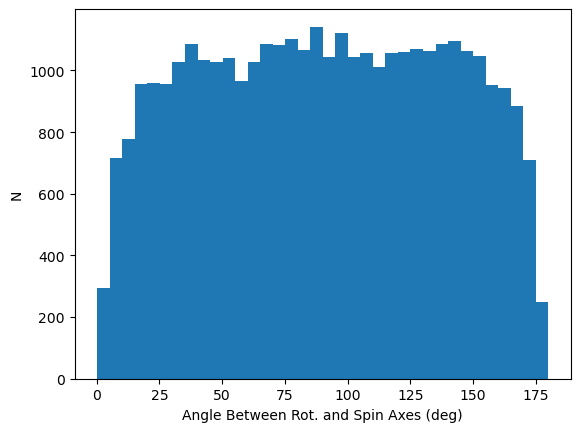

In [19]:
plt.hist(all_angles, 'scott')
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')

In [9]:
# defining the top hat kernel
def K(u):
    if (u<=1):
        return 1/2
    else:
        return 0

def KDE(x_input,h,data):
    output = np.zeros(len(x_input))
    for i,x in enumerate(x_input):
        for j, xj in enumerate(data):
            output[i] += 1/h*K(np.abs((x-xj)/h))
        output[i] = output[i]/len(data)
    return output

def silverman(data):
    std = np.std(data)
    m = stats.iqr(data)/1.34
    if (std) < m:
        m = std
    return 0.9*m*(len(data))**(-1/5)

Text(0.5, 1.0, 'KDE with top hat kernel')

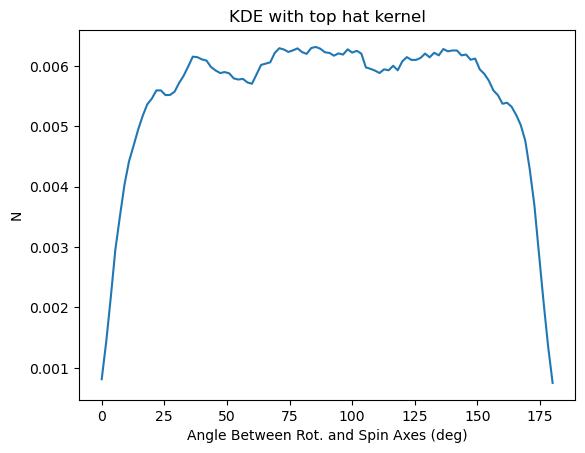

In [11]:
h = silverman(all_angles)

x = np.linspace(0,180,100)

KDE_data = KDE(x, h, all_angles)

plt.plot(x,KDE_data)
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')
plt.title('KDE with top hat kernel')

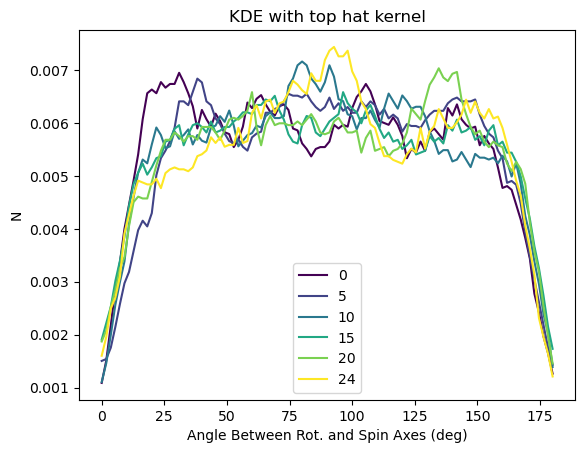

In [63]:
sorted_angles = np.empty([1,25])
for GrNr in naive_halos:
    angle_file = savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap)
    if exists(angle_file):
        temp = np.load(angle_file,allow_pickle=True)
        sorted_angles = np.vstack((sorted_angles, temp))
        
h = [silverman(sorted_angles[:,i]) for i in np.arange(25)]
x = np.linspace(0,180,100)

KDE_data = [KDE(x, h[i], sorted_angles[:,i]) for i in np.arange(25)]
colors = plt.cm.viridis(np.linspace(0, 1, 6))

for idx,i in enumerate([0,5,10,15,20,24]):
    plt.plot(x,KDE_data[i],color=colors[idx],label=str(i))
    
plt.xlabel('Angle Between Rot. and Spin Axes (deg)')
plt.ylabel('N')
plt.title('KDE with top hat kernel')
plt.legend()

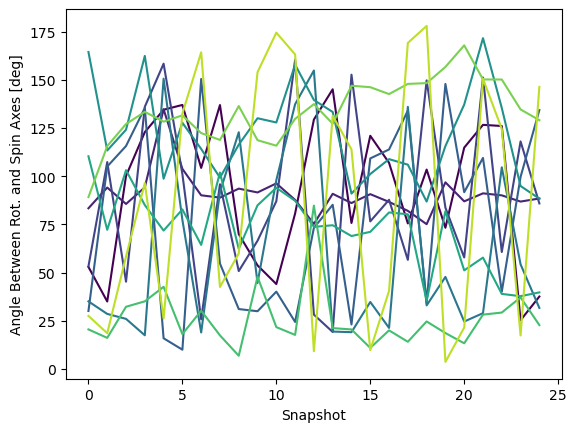

In [14]:
x = np.arange(25)
colors = plt.cm.viridis(np.linspace(0, 1, 11))
for i,GrNr in enumerate([9989,9092,8519,8229,7758,7236,6161,5121,2895,10508]):
    angleRaxis = np.load(savePath+'GrNr_%d_snap_%d_99_RaxisLaxis_angle.npy'%(GrNr,startSnap),allow_pickle=True)
    plt.plot(x, angleRaxis, color=colors[i])
    plt.xlabel('Snapshot')
    plt.ylabel('Angle Between Rot. and Spin Axes [deg]')

Text(0.5, 0.92, 'Spin Axis Over Time')

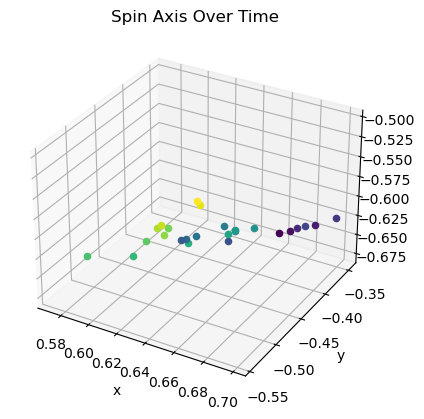

In [12]:
x = np.arange(25)
colors = plt.cm.viridis(np.linspace(0, 1, 25))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

GrNr = 516
spinAxis = np.load(spin_path + 'GrNr_%d_snap_%d_99_lambda_prime_baryons.npy'%(GrNr,startSnap),allow_pickle=True)
for snap in np.arange(25):
    ax.scatter(spinAxis[snap][0],spinAxis[snap][1],spinAxis[snap][2], color=colors[snap])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spin Axis Over Time')